In [2]:
import pandas as pd
import numpy as np
from glob import glob

# LIAR DATASET

In [98]:
def load_csv(part):
    columns = ["id", "label", "text", "subject", "speaker", "job", "state", "party", "int0", "int1", "int2", "int3", "int4", "context"]
    return pd.read_csv("./liar_dataset/" + part + ".tsv", sep="\t", names=columns)

In [44]:
test = load_csv("test")

In [45]:
def sort_label(label):
    if label in ["pants-fire", "false", "barely-true"]:
        return "false"
    else:
        return "true"
    
def clean_df(df):
    # 6 labels pants-fire, false, barely-true, half-true, mostly-true, true
    df["label"] = df["label"].apply(lambda label: sort_label(label))
    
    # per https://arxiv.org/pdf/1905.04749.pdf they only use text and label
    filtered_df=df.loc[:, ["id", "label", "text"]]
    
    return filtered_df

In [46]:
clean_df(test)

,id,label,text
0,11972.json,true,Building a wall on the U.S.-Mexico border will...
1,11685.json,false,Wisconsin is on pace to double the number of l...
2,11096.json,false,Says John McCain has done nothing to help the ...
3,5209.json,true,Suzanne Bonamici supports a plan that will cut...
4,9524.json,false,When asked by a reporter whether hes at the ce...
...,...,...,...
1262,7334.json,true,Says his budget provides the highest state fun...
1263,9788.json,false,Ive been here almost every day.
1264,10710.json,false,"In the early 1980s, Sen. Edward Kennedy secret..."
1265,3186.json,false,Says an EPA permit languished under Strickland...


In [40]:
for part in ["train", "test", "valid"]:
    df = load_csv(part)
    df = clean_df(df)
    df.to_csv("./liar_dataset/clean_" + part + ".csv")

## Post processing
Clean output from triple extractor

In [8]:
def bug_clean(df):
    condition = np.logical_and(df.triple.notna(), df.text.isna())
    indxs = df[condition]["Unnamed: 0"].values
    triples = df[condition]["triple"].values
    df.loc[indxs, "triple"] = triples
    df.drop(df.index[condition], inplace=True)
    return df

In [332]:
paths = glob("./liar_dataset_triples/*")

In [333]:
main_df = pd.DataFrame()
for path in paths:
    if not path.__contains__("train"):
        continue
    curr_df = pd.read_csv(path)
    curr_df = bug_clean(curr_df)
    main_df = pd.concat([main_df, curr_df])

In [334]:
main_df = main_df.drop(columns=list(set(main_df.columns.values) ^ set(["id", "label", "text", "triple"]))).drop_duplicates()

In [335]:
main_df.to_csv("./liar_dataset_triples/main_train_clean_triples.csv")

In [4]:
def percent_triples(df):
    return 1 - sum(df.triple.isna()) / df.shape[0]

def avg_word_count(df):
    tot = 0
    for sent in df.text.values:
        tot += len(sent.split(" "))
    return tot / df.shape[0]

In [5]:
paths = glob("./liar_dataset_triples/*")

In [6]:
drops = []
for indx, path in enumerate(paths):
    if path.__contains__("clean_train_triple"):
        drops.append(indx)
paths = np.delete(paths, drops)

In [9]:
for path in paths:
    name = "train"
    if path.__contains__("test"):
        name = "test"
    if path.__contains__("valid"):
        name = "valid"
    df = pd.read_csv(path)    
    df = bug_clean(df)
    p_triples = percent_triples(df)
    sent_size = avg_word_count(df)
    print(f"dataset: {name}. avg sent length: {sent_size:.2f} words. percent triples: {p_triples*100:.2f}%.")

dataset: test. avg sent length: 18.24 words. percent triples: 11.68%.
dataset: valid. avg sent length: 17.93 words. percent triples: 11.06%.
dataset: train. avg sent length: 17.97 words. percent triples: 3.39%.


In [10]:
df

,Unnamed: 0,id,label,text,triple
0,0,2635.json,False,Says the Annies List political group supports ...,NaN
1,1,10540.json,True,When did the decline of coal start? It started...,NaN
2,2,324.json,True,Hillary Clinton agrees with John McCain by vot...,NaN
3,3,1123.json,False,Health care reform legislation is likely to ma...,NaN
4,4,9028.json,True,The economic turnaround started at the end of ...,NaN
...,...,...,...,...,...
10234,2434,1592.json,True,"Under the ruling of the Supreme Court, any lob...",NaN
10235,2435,5473.json,True,There are a larger number of shark attacks in ...,NaN
10236,2436,3408.json,True,Democrats have now become the party of the Atl...,NaN
10237,2437,3959.json,True,Says an alternative to Social Security that op...,"[['County', 'location/hud_county_place/county'..."


In [6]:
#!pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

In [44]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


def fb_to_common(freebase_id):
    endpoint_url = "https://query.wikidata.org/sparql"

    query = \
    '''SELECT ?sLabel WHERE { 
        ?s wdt:P646 "''' + freebase_id + '''".
        SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''
    res = get_results(endpoint_url, query)
    try:
        res = res['results']['bindings'][0]['sLabel']['value']
        return res
    except:
        return "No result"

def common_to_fb(common_name):
    endpoint_url = "https://query.wikidata.org/sparql"
    
    if common_name.islower():
        common_name = common_name.capitalize() + "s"

    query = '''
    SELECT ?fbid WHERE { 
        ?s wdt:P373 "''' + common_name + '''".
    OPTIONAL {
        ?s wdt:P646 ?fbid .
        }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''
    res = get_results(endpoint_url, query)
    try:
        res = res['results']['bindings'][0]['fbid']['value']
        return res
    except:
        return common_name + "-1"

In [235]:
train = pd.read_csv("./liar_dataset_triples/train.csv", index_col=0)
valid = pd.read_csv("./liar_dataset_triples/valid.csv", index_col=0)
test = pd.read_csv("./liar_dataset_triples/test.csv", index_col=0)

In [217]:
def clean_df(df):
    df = df.dropna()
    df.drop_duplicates(inplace=True)
    df.triple = df.triple.apply(lambda x: eval(x))
    df = df.reset_index()
    df = df[["id", "label", "triple"]]
    return df

In [248]:
def expand_df(df):
    expanded_df = pd.DataFrame(columns=["text_id", "head", "relation", "tail", "label"])
    for text_id, label, triples in df.values:
        for h, r, t in triples:
            expanded_df = expanded_df.append({
                "text_id": text_id, 
                "head": h, 
                "relation": r, 
                "tail": t, 
                "label": label
            }, ignore_index=True)
    return expanded_df

In [26]:
!pip install beautifulsoup4

     |████████████████████████████████| 115 kB 830 kB/s eta 0:00:01


In [27]:
import requests 
import urllib
from bs4 import BeautifulSoup

# desktop user-agent
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
# mobile user-agent
MOBILE_USER_AGENT = "Mozilla/5.0 (Linux; Android 7.0; SM-G930V Build/NRD90M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.125 Mobile Safari/537.36"

def google(query):
    query = query.replace(' ', '+')
    URL = f"https://google.com/search?q={query}&hl=en"
    
    headers = {"user-agent" : USER_AGENT}
    resp = requests.get(URL, headers=headers)
    
    if resp.status_code == 200:
        soup = BeautifulSoup(resp.content, "html.parser")
        for g in soup.find_all("div", {"class": "g"}):
            titles = g.find_all("h3")
            if titles:
                text = titles[0].text
                if "Wikipedia" in text:
                    return text[:-12]
                if "Ballotpedia" in text:
                    return text[:-14]
    if resp.status_code == 429:
        print("Blocked!")
        return False
    return query

In [28]:
from tqdm import tqdm
import time

def google_triples(df):

    # iterate list of list 
    for i, pair in enumerate(tqdm(df[["head", "tail"]].values)):
        h = google(pair[0])
        t = google(pair[-1])
        if not bool(h) and not bool(t):
            return df
        time.sleep(2.1)
        df.at[i, 'head'] = h
        df.at[i, 'tail'] = t
    return df

In [262]:
t = "Scott Walker (Singer)"

In [270]:
remove_par(t)

'Scott Walker'

In [271]:
re.sub(r'.\(.*\)', "", t)

'Scott Walker'

In [272]:
import re
def remove_par(t):
    return re.sub(r'.\(.*\)', "", t)

In [274]:
def transform(df, name):
    df = clean_df(df)
    df = expand_df(df)
    df = google_triples(df)
    df['head'] = df["head"].apply(lambda x: remove_par(x))
    df['tail'] = df["tail"].apply(lambda x: remove_par(x))
    df.to_csv("./liar_dataset_triples/" + name + ".csv")

In [275]:
train = pd.read_csv("./liar_dataset_triples/train.csv", index_col=0)
valid = pd.read_csv("./liar_dataset_triples/valid.csv", index_col=0)
test = pd.read_csv("./liar_dataset_triples/test.csv", index_col=0)

In [276]:
transform(train, "train_google")
transform(valid, "valid_google")
transform(test, "test_google")

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [277]:
google_train = pd.read_csv("./liar_dataset_triples/train_google.csv", index_col=0)
google_valid = pd.read_csv("./liar_dataset_triples/valid_google.csv", index_col=0)
google_test = pd.read_csv("./liar_dataset_triples/test_google.csv", index_col=0)

In [286]:
google_train

,text_id,head,relation,tail,label
0,6873.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,False
1,7976.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,True
2,2354.json,Kristi Thibaut,organization/role/leaders./organization/leader...,Acorn,True
3,2354.json,Kristi Thibaut,people/person/employment_history./business/emp...,State+Rep.,True
4,980.json,Timothy Geithner,people/person/employment_history./business/emp...,Secretary,False
...,...,...,...,...,...
448,1550.json,Perry,people/person/employment_history./business/emp...,.gov,True
449,6032.json,Stan Wise,organization/role/leaders./organization/leader...,Georgia Public Service Commission,True
450,3744.json,Barack Obama,people/person/employment_history./business/emp...,President of the United States,True
451,4388.json,Fung,people/person/employment_history./business/emp...,Mayor,False


In [292]:
o_train = clean_df(train)
o_train = expand_df(o_train)
o_valid = clean_df(valid)
o_valid = expand_df(o_valid)
o_test = clean_df(test)
o_test = expand_df(o_test)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [293]:
google_train["o_head"] = o_train["head"]
google_train["o_tail"] = o_train["tail"]
google_valid["o_head"] = o_valid["head"]
google_valid["o_tail"] = o_valid["tail"]
google_test["o_head"] = o_test["head"]
google_test["o_tail"] = o_test["tail"]

In [303]:
google_train.to_csv("./liar_dataset_triples/train_cleaning.csv")
google_valid.to_csv("./liar_dataset_triples/valid_cleaning.csv")
google_test.to_csv("./liar_dataset_triples/test_cleaning.csv")

TypeError: to_csv() got an unexpected keyword argument 'index_col'

In [361]:
test_fix = pd.read_csv("./liar_dataset_triples/test_fix_1.csv", sep=";", header=0,  error_bad_lines=False)

In [367]:
def add_hash(df):
    fb_hash = []
    for h in df['head'].values:
        fb = common_to_fb(h)
        if not "/m/" in fb:
            fb_hash.append(h)
        else:
            fb_hash.append(fb)
    df["fb_head"] = fb_hash
    fb_hash = []
    for t in df['tail'].values:
        fb = common_to_fb(t)
        if not "/m/" in fb:
            fb_hash.append(t)
        else:
            fb_hash.append(fb)
    df["fb_tail"] = fb_hash
    return df

In [363]:
test_fix = add_hash(test_fix)

In [368]:
valid_fix = add_hash(google_valid)

In [369]:
train_fix = add_hash(google_train)

In [370]:
train_fix.to_csv("./liar_dataset_triples/train_processed.csv")
valid_fix.to_csv("./liar_dataset_triples/valid_processed.csv")
test_fix.to_csv("./liar_dataset_triples/test_processed.csv")

In [433]:
valid_fix = pd.read_csv("./liar_dataset_triples/valid_processed.csv", index_col=0, header=0,  error_bad_lines=False)

In [53]:
test_fix = pd.read_csv("./liar_dataset_triples/test_hashed.csv", sep=";", header=0,  error_bad_lines=False)

In [435]:
valid_fix = valid_fix.replace("Gov.", "governor")
valid_fix = valid_fix.replace(".gov", "governor")
valid_fix = valid_fix.replace("Governor", "governor")

In [437]:
for i in range(valid_fix.shape[0]-1):
    if sum(test_fix['head'] == valid_fix.at[i, 'head']) > 0:
        valid_fix.at[i, 'fb_head'] = test_fix[test_fix['head'] == valid_fix.at[i, 'head']]['fb_head'].values[0]
        
    if sum(test_fix['tail'] == valid_fix.at[i, 'tail']) > 0:
        valid_fix.at[i, 'fb_tail'] = test_fix[test_fix['tail'] == valid_fix.at[i, 'tail']]['fb_tail'].values[0]

In [444]:
valid_fix.to_csv("./liar_dataset_triples/valid_hashed.csv")

In [455]:
train_fix = train_fix.replace("Gov.", "governor")
train_fix = train_fix.replace(".gov", "governor")
train_fix = train_fix.replace("Governor", "governor")

In [471]:
fb_to_common("/m/0f8t6k")

'Chris Christie'

In [456]:
for i in range(train_fix.shape[0]-1):
    if sum(valid_fix['head'] == train_fix.at[i, 'head']) > 0:
        train_fix.at[i, 'fb_head'] = valid_fix[valid_fix['head'] == train_fix.at[i, 'head']]['fb_head'].values[0]
        
    if sum(valid_fix['tail'] == train_fix.at[i, 'tail']) > 0:
        train_fix.at[i, 'fb_tail'] = valid_fix[valid_fix['tail'] == train_fix.at[i, 'tail']]['fb_tail'].values[0]

In [457]:
train_fix.to_csv("./liar_dataset_triples/train_hashed.csv")

In [474]:
train[train.id == "5401.json"].text.values

array(['As Virginias governor, Allen cut spending and waste with bipartisan support.'],
      dtype=object)

# FakeNewsNet 

In [10]:
paths = glob("./fakenewsnet/*/*/*")

In [11]:
df = pd.DataFrame(columns=["text", "source", "label"])

In [12]:
def get_content(data):
    text = data['text']
    label = "false" if (path.split("\\")[-2] == "FakeNewsContent") else "true"
    source = path.split("\\")[1]
    return {"text":text, "source": source, "label": label}

In [14]:
from tqdm import tqdm
import json
for path in tqdm(paths):
    with open(path) as f:
        data = json.load(f)
    content = get_content(data)
    df = df.append(content, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████| 422/422 [00:02<00:00, 150.19it/s]


In [15]:
buzzfeed = df[df.source == "BuzzFeed"]
politifact = df[df.source == "PolitiFact"]
print(f"""
    BuzzFeed:
    num articles: {buzzfeed.shape[0]},
        false: {sum(buzzfeed.label == "false")},
        true: {sum(buzzfeed.label == "true")}
    
    PolitiFact:
    num articles: {politifact.shape[0]},
        false: {sum(politifact.label == "false")},
        true: {sum(politifact.label == "true")}
""")


    BuzzFeed:
    num articles: 182,
        false: 91,
        true: 91
    
    PolitiFact:
    num articles: 240,
        false: 120,
        true: 120



In [461]:
df.to_csv("./fakenewsnet/clean_fakenewsnet.csv")

In [19]:
df.iloc[219]

text                
source    PolitiFact
label          false
Name: 219, dtype: object

## inspection

In [3]:
df = pd.read_csv("./fakenewsnet/clean_fakenewsnet.csv", index_col=0)

In [4]:
df = df.dropna()

In [5]:
df["source"] = df["source"].replace("BuzzFeed", "GossipCop")

In [6]:
df.text.apply(lambda x: sum(map(len, x.split(" ")))/float(len(x.split(" "))))

0      5.190385
1      5.772414
2      4.894737
3      5.136364
4      5.400000
         ...   
417    5.069751
418    4.820449
419    5.000963
420    5.000000
421    5.771084
Name: text, Length: 420, dtype: float64

In [7]:
df["word_count"] = df.text.apply(lambda x: len(x.split(" ")))
df["avg_word_length"] = df.text.apply(lambda x: sum(map(len, x.split(" ")))/float(len(x.split(" "))))

In [8]:
df

,text,source,label,word_count,avg_word_length
0,I woke up this morning to find a variation of ...,GossipCop,False,520,5.190385
1,Former President Bill Clinton and his Clinton ...,GossipCop,False,1305,5.772414
2,After collapsing just before trying to step in...,GossipCop,False,589,4.894737
3,"Donald Trump is, well, deplorable. He’s sugges...",GossipCop,False,726,5.136364
4,Website is Down For Maintenance,GossipCop,False,5,5.400000
...,...,...,...,...,...
417,"KALLSTADT, Germany — Few places in Germany are...",PolitiFact,True,1448,5.069751
418,Hollywood loses yet another one of their deare...,PolitiFact,True,401,4.820449
419,"As my 25th wedding anniversary approached, I t...",PolitiFact,True,2077,5.000963
420,Story highlights Trump was sitting in a chair ...,PolitiFact,True,220,5.000000


In [11]:
#!pip install seaborn

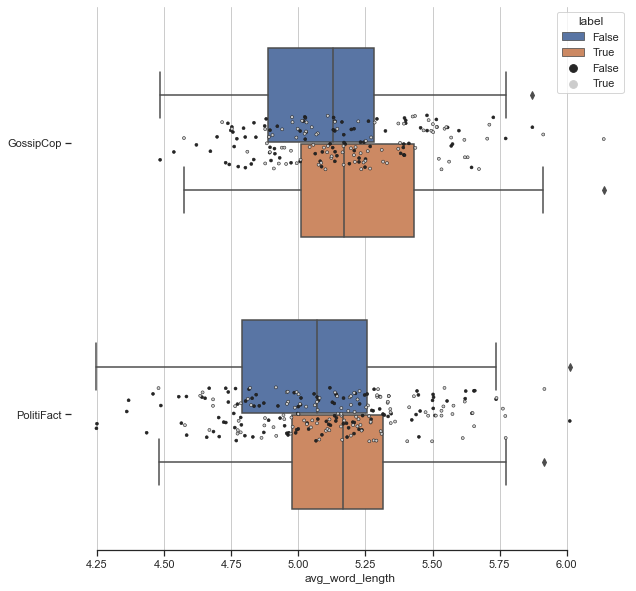

In [66]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(10, 10))
#ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="avg_word_length", y="source", hue="label", data=df,
             width=.7, )

# Add in points to show each observation
sns.stripplot(x="avg_word_length", y="source", hue="label", data=df,
              size=3, color=".8", linewidth=0.5)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="");
sns.despine(trim=True, left=True)

In [67]:
plt.savefig("sample.png")

<Figure size 432x288 with 0 Axes>

In [13]:
#!pip install --upgrade gensim

In [15]:
import re
def clean_text(text):
    return re.sub("[^a-zA-Z0-9.,]", " ", text)

In [16]:
df.text = df.text.apply(lambda x: clean_text(x))

In [102]:
from gensim import models

tfidf = models.TfidfModel(corpus)  # step 1 -- initialize a model

In [110]:
corpus_tfidf = tfidf[corpus]

lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=300)  # initialize an LSI transformation
corpus_lsi = lsi_model[corpus_tfidf]  # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi


In [117]:
lsi_model.print_topics(3)

[(0,
  '-0.188*"trump" + -0.153*"clinton" + -0.138*"she" + -0.137*"i" + -0.131*"her" + -0.104*"debate" + -0.098*"he" + -0.096*"obama" + -0.093*"you" + -0.088*"hillary"'),
 (1,
  '-0.249*"police" + 0.235*"debate" + -0.228*"charlotte" + 0.205*"clinton" + 0.179*"trump" + -0.169*"scott" + -0.131*"officers" + -0.129*"black" + -0.121*"hawkins" + 0.120*"poll"'),
 (2,
  '0.482*"mccain" + 0.409*"arpaio" + 0.335*"sheriff" + 0.260*"joe" + 0.188*"eviscerated" + 0.188*"pardon" + 0.188*"lawman" + 0.179*"pardoning" + 0.179*"fires" + 0.160*"toughest"')]

In [124]:
np.argmax([e[1] for e in corpus_lsi[0]])

105

In [125]:
lsi_model.show_topic(105)

[('carlson', -0.08994315216427769),
 ('cher', 0.0818455203209985),
 ('houston', 0.07857653072079976),
 ('stafford', 0.07790227205582576),
 ('concert', -0.07602132968164746),
 ('jeremy', 0.07532402541068883),
 ('palin', -0.07433214885897806),
 ('moon', 0.06863369235538903),
 ('driving', -0.06833968853241346),
 ('zero', 0.06533696522925976)]

In [19]:
#!pip install sentence-transformers

In [32]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

In [34]:
data = df.text.values

In [36]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-uncased')
embeddings = model.encode(data, show_progress_bar=True)

Exception when trying to download http://sbert.net/models/bert-base-uncased.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/bert-base-uncased.zip not found. Try to create it from scratch
Try to create Transformer Model bert-base-uncased with mean pooling


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [37]:
#!pip install umap-learn

In [38]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [39]:
#!pip install hdbscan

In [40]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

<IPython.core.display.Javascript object>


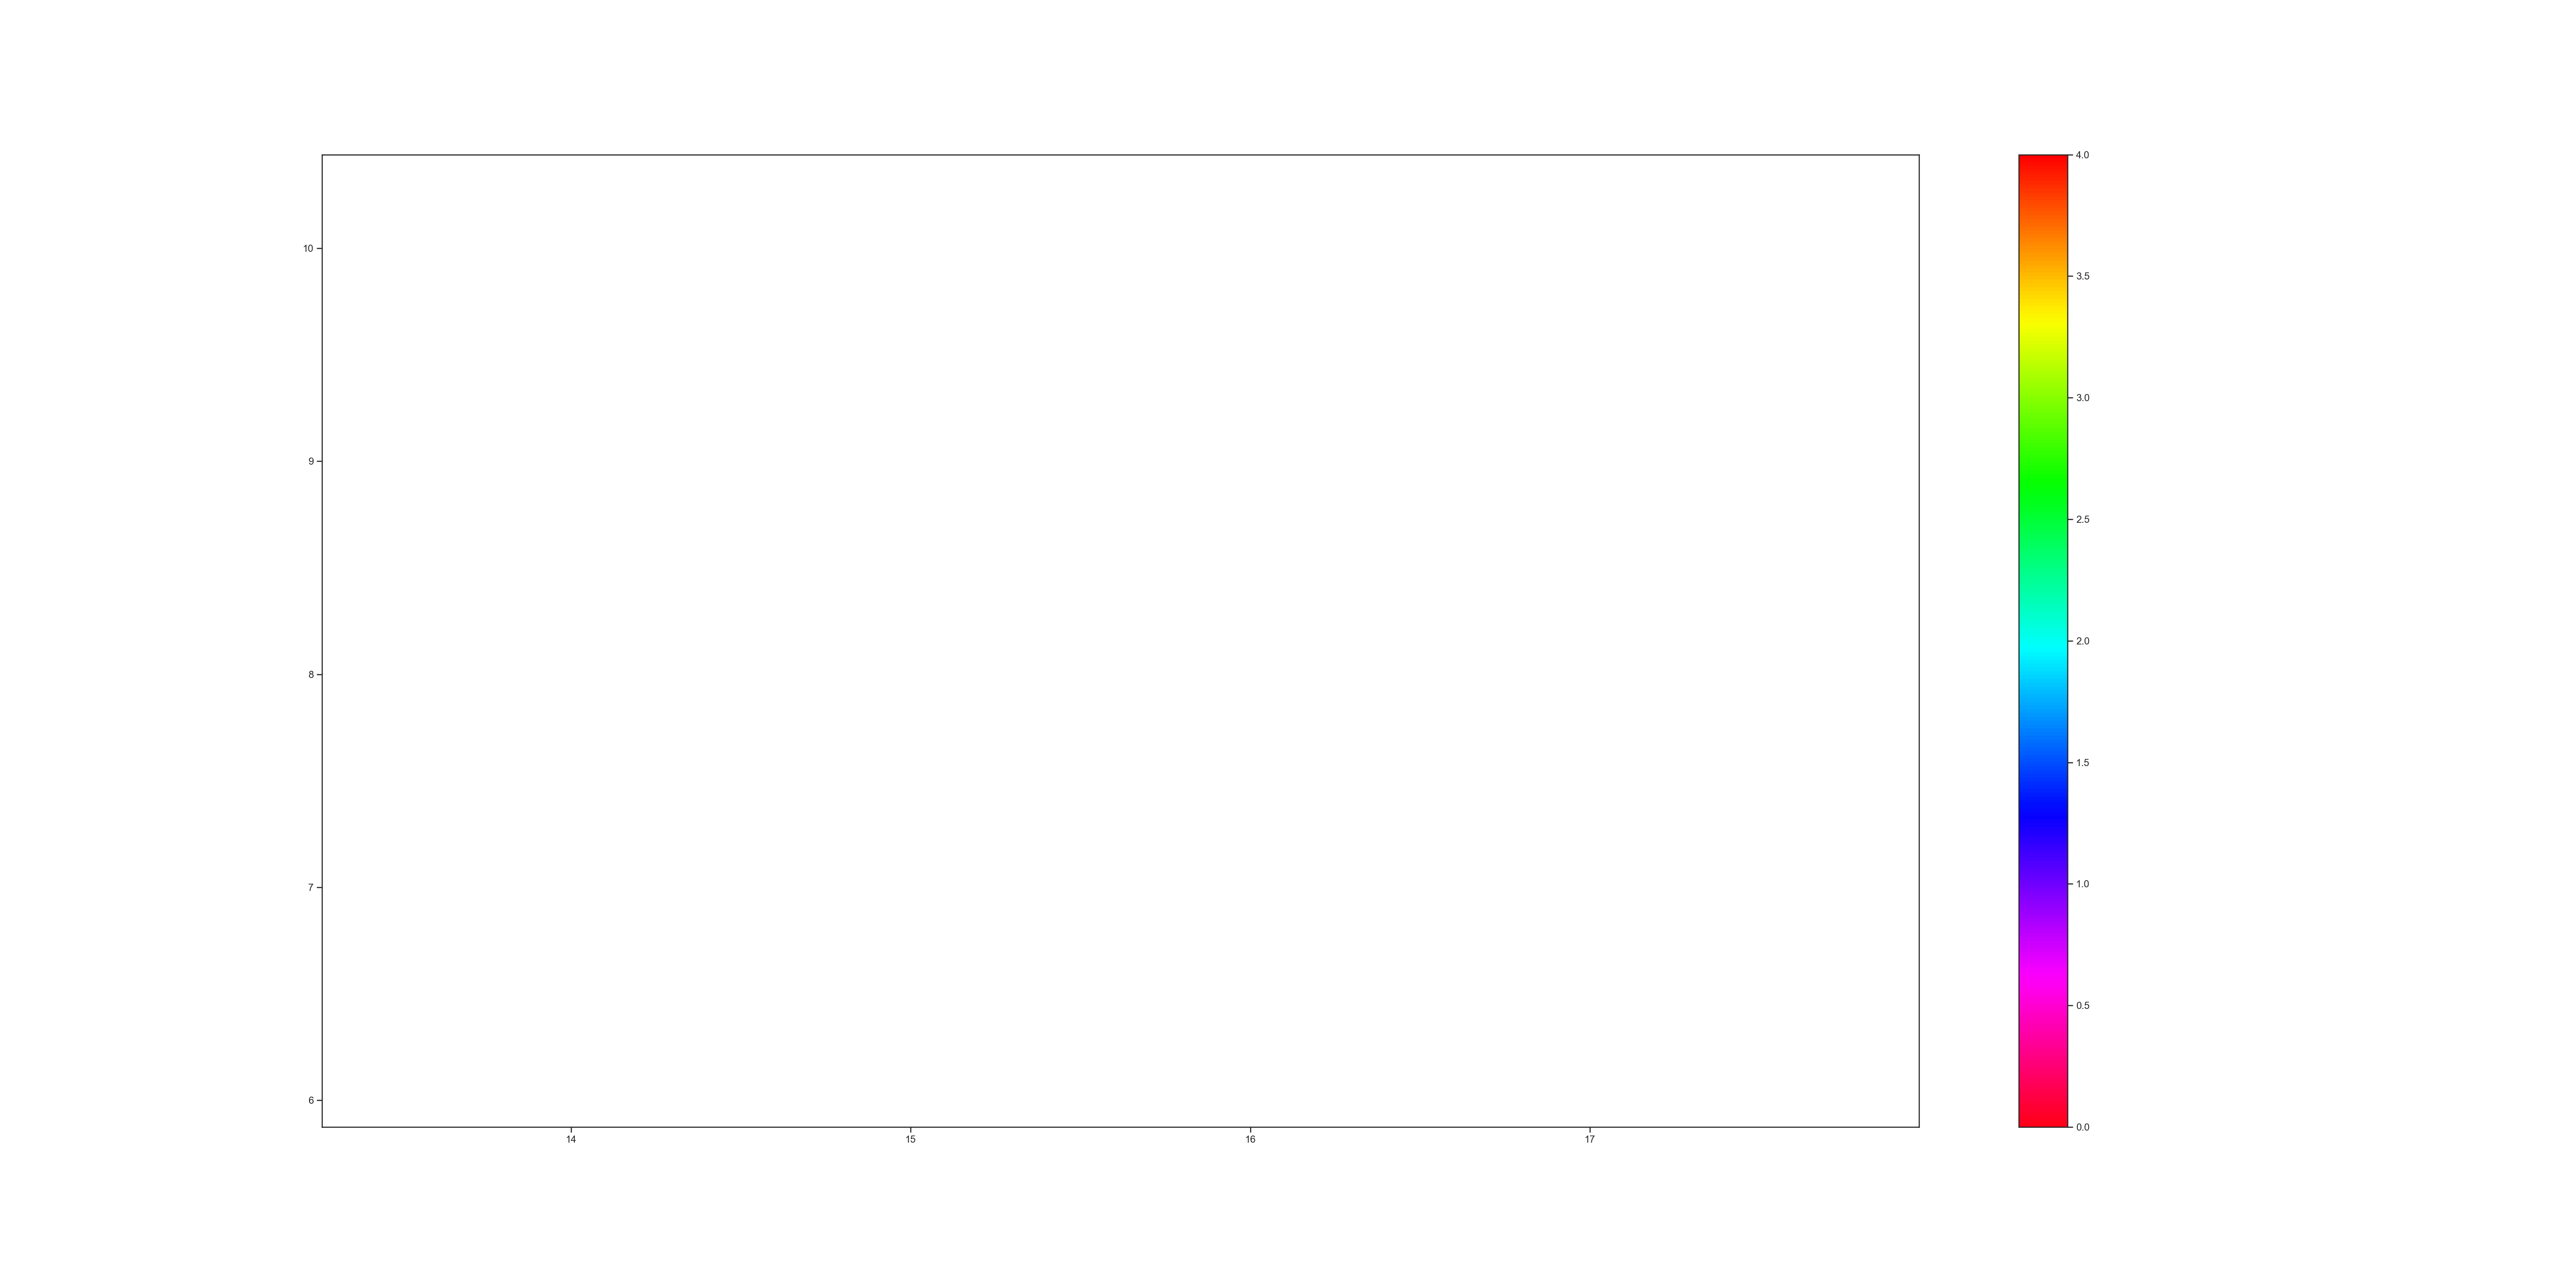

In [63]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=150, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=15.35)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15.35, cmap='hsv_r')
plt.colorbar();

## Post processing
Clean output from triple extractor

In [2]:
def load_df(path):
    df = pd.read_csv(paths[0])
    return df[["text", "source", "label", "triple"]]

In [3]:
paths = glob("./fakenewsnet_triples/*")

In [9]:
paths

['./fakenewsnet_triples/hashed.csv',
 './fakenewsnet_triples/googled.csv',
 './fakenewsnet_triples/wiki_hashed.xlsx',
 './fakenewsnet_triples/wiki_hashed_manual.xlsx',
 './fakenewsnet_triples/wiki_hashed.csv',
 './fakenewsnet_triples/fakenewsnet_triples_trimmed.csv']

In [20]:
df = pd.read_csv(paths[1], index_col=0)

In [21]:
df

,Unnamed: 0,id_text,head,relation,tail,label,text_id
0,0,NaN,Bill Clinton,organization/role/leaders./organization/leader...,NPR,False,0.0
1,1,NaN,Bill Clinton,people/person/employment_history./business/emp...,President of the United States,False,1.0
2,2,NaN,Marsha Blackburn,people/person/employment_history./business/emp...,Rep,False,1.0
3,3,NaN,Roger Bate,organization/role/leaders./organization/leader...,American Enterprise Institute,False,1.0
4,4,NaN,Hillary Clinton,people/person/employment_history./business/emp...,Candidate,False,1.0
...,...,...,...,...,...,...,...
995,995,NaN,William H. Seward,organization/role/leaders./organization/leader...,Republican Party,True,415.0
996,996,NaN,John Tyler,people/person/employment_history./business/emp...,President of the United States,True,415.0
997,997,NaN,Donald Trump,people/person/employment_history./business/emp...,President of the United States,True,415.0
998,998,NaN,Hillary Clinton,people/person/employment_history./business/emp...,President of the United States,True,415.0


In [16]:
df.iloc[11].triple

AttributeError: 'Series' object has no attribute 'triple'

In [12]:
df.iloc[11].text

'Thanks in part to the declassification of Defense Intelligence documents, connecting those missing dots seems to have finally reveled what most Middle East observers have suspected all along, that the rise of the terrorist group ISIS and the likelihood of establishing a terror state a caliphate, had been predicated by both the CIA and DIA, as far back as 2012.And purposely created by the Obama Administration in part to isolate the Syrian government of President Bashar alAssad. The documents also predicted that the support given by the West, Turkey and the Persian Gulf Arab states to the Takfiri militants would eventually lead to the establishment of a Salafist Principality in Eastern Syria.According to investigative reporter Nafeez Ahmed, the leaked document reveals that in coordination with the Gulf states and Turkey, the West intentionally sponsored violent Islamist groups to destabilize Assad, despite anticipating that doing so could lead to the emergence of an Islamic State in Ira

In [73]:
for i in range(df.shape[0]):
    if type(df.iloc[i].text) != np.float:
        if "National Republican Senatorial Committee" in df.iloc[i].text:
            print(i)


397


c:\users\oddgu\programming\text2rdf\venv\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [75]:
clean = pd.DataFrame(columns=["id_text","text", "source", "label", "triple"])
for i in range(df.shape[0]):
    if type(df.iloc[i].text) != np.float:
        t = df.iloc[i].values
        clean = clean.append({
                "id_text": i,
                "text": t[1],
                "source": t[2],
                "label": t[3],
                "triple": t[4]
            }, ignore_index=True)

c:\users\oddgu\programming\text2rdf\venv\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [77]:
paths

['./fakenewsnet_triples\\clean_fakenewsnet_triple.csv']

In [78]:
clean.to_csv("./fakenewsnet_triples/fakenewsnet_triples_trimmed.csv")

In [5]:
trimmed = pd.read_csv("./fakenewsnet_triples/fakenewsnet_triples_trimmed.csv", index_col=0)

In [30]:
def clean_df(df):
    df = df.dropna()
    df.drop_duplicates(inplace=True)
    df.triple = df.triple.apply(lambda x: eval(x))
    df = df.reset_index()
    df = df[["id_text", "label", "triple"]]
    return df

In [31]:
def expand_df(df):
    expanded_df = pd.DataFrame(columns=["text_id", "head", "relation", "tail", "label"])
    for text_id, label, triples in df.values:
        for h, r, t in triples:
            expanded_df = expanded_df.append({
                "text_id": text_id, 
                "head": h, 
                "relation": r, 
                "tail": t, 
                "label": label
            }, ignore_index=True)
    return expanded_df

In [32]:
import re
from tqdm import tqdm
import time

def remove_par(t):
    return re.sub(r'.\(.*\)', "", t)

def clean_df(df):
    df = df.dropna()
    df.drop_duplicates(inplace=True)
    df.triple = df.triple.apply(lambda x: eval(x))
    df = df.reset_index()
    df = df[["id_text", "label", "triple"]]
    return df

def expand_df(df):
    expanded_df = pd.DataFrame(columns=["id_text", "head", "relation", "tail", "label"])
    for text_id, label, triples in df.values:
        for h, r, t in triples:
            expanded_df = expanded_df.append({
                "text_id": text_id, 
                "head": h, 
                "relation": r, 
                "tail": t, 
                "label": label
            }, ignore_index=True)
    return expanded_df

def google_triples(df):

    # iterate list of list 
    for i, pair in enumerate(tqdm(df[["head", "tail"]].values)):
        h = google(pair[0])
        t = google(pair[-1])
        if not bool(h) and not bool(t):
            return df
        time.sleep(2.1)
        df.at[i, 'head'] = h
        df.at[i, 'tail'] = t
    return df

def transform(df, name):
    df = clean_df(df)
    df = expand_df(df)
    df = google_triples(df)
    df['head'] = df["head"].apply(lambda x: remove_par(x))
    df['tail'] = df["tail"].apply(lambda x: remove_par(x))
    df.to_csv("./fakenewsnet_triples/" + name + ".csv")

In [27]:
trimmed[trimmed.id_text == 251].text.values

array(['Backstages auditions in Houston, Texas, include theater, film, television, commercials, and voiceover roles. New Houston auditions are posted to Backstage.com daily. You can further refine your search by age range, production type, gender, union status and more, and save your search to have new Dallas casting notices sent directly to your inb'],
      dtype=object)

In [35]:
transform(trimmed, "googled")

/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
100%|██████████| 1000/1000 [1:38:26<00:00,  5.91s/it]


In [36]:
googled = pd.read_csv("./fakenewsnet_triples/googled.csv", index_col=0)

In [50]:
def add_hash(df):
    fb_hash = []
    for h in df['head'].values:
        fb = common_to_fb(h)
        if not "/m/" in fb:
            fb_hash.append(h)
        else:
            fb_hash.append(fb)
    df["fb_head"] = fb_hash
    fb_hash = []
    for t in df['tail'].values:
        fb = common_to_fb(t)
        if not "/m/" in fb:
            fb_hash.append(t)
        else:
            fb_hash.append(fb)
    df["fb_tail"] = fb_hash
    return df

In [51]:
hashed = add_hash(googled)

In [52]:
hashed

,id_text,head,relation,tail,label,text_id,fb_head,fb_tail
0,NaN,Bill Clinton,organization/role/leaders./organization/leader...,NPR,False,0.0,/m/0157m,NPR
1,NaN,Bill Clinton,people/person/employment_history./business/emp...,President of the United States,False,1.0,/m/0157m,President of the United States
2,NaN,Marsha Blackburn,people/person/employment_history./business/emp...,Rep,False,1.0,/m/01fnkt,/m/07r8g3
3,NaN,Roger Bate,organization/role/leaders./organization/leader...,American Enterprise Institute,False,1.0,Roger Bate,/m/0p8q4
4,NaN,Hillary Clinton,people/person/employment_history./business/emp...,Candidate,False,1.0,Hillary Clinton,Candidate
...,...,...,...,...,...,...,...,...
995,NaN,William H. Seward,organization/role/leaders./organization/leader...,Republican Party,True,415.0,/m/0k_2z,Republican Party
996,NaN,John Tyler,people/person/employment_history./business/emp...,President of the United States,True,415.0,/m/042dk,President of the United States
997,NaN,Donald Trump,people/person/employment_history./business/emp...,President of the United States,True,415.0,/m/0cqt90,President of the United States
998,NaN,Hillary Clinton,people/person/employment_history./business/emp...,President of the United States,True,415.0,Hillary Clinton,President of the United States


In [54]:
test_fix = pd.read_csv("./liar_dataset_triples/test_hashed.csv", sep=";", header=0,  error_bad_lines=False)
hashed = hashed.replace("Gov.", "governor")
hashed = hashed.replace(".gov", "governor")
hashed = hashed.replace("Governor", "governor")
for i in range(hashed.shape[0]-1):
    if sum(test_fix['head'] == hashed.at[i, 'head']) > 0:
        hashed.at[i, 'fb_head'] = test_fix[test_fix['head'] == hashed.at[i, 'head']]['fb_head'].values[0]
        
    if sum(test_fix['tail'] == hashed.at[i, 'tail']) > 0:
        hashed.at[i, 'fb_tail'] = test_fix[test_fix['tail'] == hashed.at[i, 'tail']]['fb_tail'].values[0]

In [56]:
test_fix = pd.read_csv("./liar_dataset_triples/valid_hashed.csv", sep=";", header=0,  error_bad_lines=False)


for i in range(hashed.shape[0]-1):
    if sum(test_fix['head'] == hashed.at[i, 'head']) > 0:
        hashed.at[i, 'fb_head'] = test_fix[test_fix['head'] == hashed.at[i, 'head']]['fb_head'].values[0]
        
    if sum(test_fix['tail'] == hashed.at[i, 'tail']) > 0:
        hashed.at[i, 'fb_tail'] = test_fix[test_fix['tail'] == hashed.at[i, 'tail']]['fb_tail'].values[0]

In [93]:
def compare(base, target):
    for i in range(base.shape[0]-1):
        for x in ["head", "tail"]:
            for y in ["head", "tail"]:
                if sum(test_fix[x] == hashed.at[i, y]) > 0:
                    hashed.at[i, f'fb_{y}'] = test_fix[test_fix[x] == hashed.at[i, y]]['fb_head'].values[0]

In [151]:
LIAR_train = pd.read_csv("./liar_dataset_triples/train_hashed.csv", sep=";", header=0,  error_bad_lines=False)
LIAR_valid = pd.read_csv("./liar_dataset_triples/valid_hashed.csv", sep=";", header=0,  error_bad_lines=False)
LIAR_test = pd.read_csv("./liar_dataset_triples/test_hashed.csv", sep=";", header=0,  error_bad_lines=False)

compare(hashed, LIAR_train)
compare(hashed, LIAR_valid)
compare(hashed, LIAR_test)

In [144]:
def get_query(q):
    return '''
    SELECT ?fbid WHERE { 
        ?s wdt:P373 "''' + q + '''".
    OPTIONAL {
        ?s wdt:P646 ?fbid .
        }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 1'''

def common_to_fb(common_name):
    endpoint_url = "https://query.wikidata.org/sparql"
    query = get_query(common_name)
    res = get_results(endpoint_url, query)
    try:
        res = res['results']['bindings'][0]['fbid']['value']
        return res
    except:
        return common_name
    
def fb_convert(common_name):
    # base
    res = common_to_fb(common_name)
    if res.__contains__("/m/"):
        return res
    res = common_to_fb(common_name.lower())
    if res.__contains__("/m/"):
        return res
    if common_name[-1] == "s":
        end = ""
    else:
        end = "s"
    res = common_to_fb(common_name.capitalize() + end)
    if res.__contains__("/m/"):
        return res
    return common_name

def add_hash(df):
    fb_hash = []
    for h in df['head'].values:
        fb = fb_convert(h)
        if not "/m/" in fb:
            fb_hash.append(h)
        else:
            fb_hash.append(fb)
    df["fb_head"] = fb_hash
    fb_hash = []
    for t in df['tail'].values:
        fb = fb_convert(t)
        if not "/m/" in fb:
            fb_hash.append(t)
        else:
            fb_hash.append(fb)
    df["fb_tail"] = fb_hash
    return df

In [130]:
for e in bad_heads:
    res = fb_convert(e)
    if res.__contains__("/m/"):
        print(e)
        break

Bank


In [147]:
hashed2 = add_hash(hashed)

In [152]:
LIAR_train = pd.read_csv("./liar_dataset_triples/train_hashed.csv", sep=";", header=0,  error_bad_lines=False)
LIAR_valid = pd.read_csv("./liar_dataset_triples/valid_hashed.csv", sep=";", header=0,  error_bad_lines=False)
LIAR_test = pd.read_csv("./liar_dataset_triples/test_hashed.csv", sep=";", header=0,  error_bad_lines=False)

compare(hashed2, LIAR_train)
compare(hashed2, LIAR_valid)
compare(hashed2, LIAR_test)

In [153]:
bad_heads = np.unique([e for e in hashed2.fb_head.values if not e.startswith("/m/")])
bad_tails = np.unique([e for e in hashed2.fb_tail.values if not e.startswith("/m/")])

In [154]:
print(len(bad_heads))
print(len(bad_tails))

192
170


In [170]:
test = hashed2["fb_head"]

In [187]:
mask = []
for e in test:
    if e.startswith("/m/"):
        mask.append(False)
    else:
        mask.append(True)

In [189]:
hashed2["fb_head"][mask]

3         Roger Bate
9                HES
18      Nafeez Ahmed
31          Michelle
32       Peter Allen
           ...      
986        Friedrich
987        Friedrich
988        Friedrich
989    Simone Wendel
993    James K. Polk
Name: fb_head, Length: 291, dtype: object

In [176]:
t = [e for e in test.values if not e.startswith("/m")]

In [179]:
t = [e.replace("+", " ") for e in t]

In [ ]:
import requests 
import urllib
from bs4 import BeautifulSoup

# desktop user-agent
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
# mobile user-agent
MOBILE_USER_AGENT = "Mozilla/5.0 (Linux; Android 7.0; SM-G930V Build/NRD90M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.125 Mobile Safari/537.36"

def google(query):
    query = query.replace(' ', '+')
    URL = f"https://google.com/search?q={query}&hl=en"
    
    headers = {"user-agent" : USER_AGENT}
    resp = requests.get(URL, headers=headers)
    
    if resp.status_code == 200:
        soup = BeautifulSoup(resp.content, "html.parser")
        for g in soup.find_all("div", {"class": "g"}):
            titles = g.find_all("h3")
            if titles:
                text = titles[0].text
                if "Wikipedia" in text:
                    return text[:-12]
                if "Ballotpedia" in text:
                    return text[:-14]
    if resp.status_code == 429:
        print("Blocked!")
        return False
    return query

In [316]:
import requests 
import urllib
from bs4 import BeautifulSoup

# desktop user-agent
USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
# mobile user-agent
MOBILE_USER_AGENT = "Mozilla/5.0 (Linux; Android 7.0; SM-G930V Build/NRD90M) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.125 Mobile Safari/537.36"


def name_to_wiki(name):
    query = name.replace(' ', '+')
    URL = "https://www.wikidata.org/w/index.php?search=" + query + "&title=Special:Search&profile=advanced&fulltext=1&ns0=1&ns120=1"
    headers = {"user-agent" : USER_AGENT}
    resp = requests.get(URL, headers=headers)

    soup = BeautifulSoup(resp.content, "html.parser")
    if soup.find("p", {"class": "mw-search-nonefound"}) == None:
        identifier = soup.find_all("span", {"class": "wb-itemlink-id"})[0].text.strip("()")
        URL2 = "https://www.wikidata.org/wiki/" + identifier
        resp = requests.get(URL2, headers=headers)
        soup = BeautifulSoup(resp.content, "html.parser")
        has_fb = soup.find("div", {"id": "P646"})
        if has_fb != None:
            fb_id = has_fb.find("a", {"class": "wb-external-id external"}).text
            return fb_id
    return name

In [334]:
from tqdm import tqdm
def add_hash_wiki(df):
    fb_hash = []
    for h in tqdm(df['fb_head'].values):
        if not "/m/" in h:
            fb = name_to_wiki(h)
            if "/m/" in fb:
                fb_hash.append(fb)
            else:
                fb_hash.append(h)
        else:
            fb_hash.append(h)

    df["fb_head"] = fb_hash
    fb_hash = []
    for t in tqdm(df['fb_tail'].values):
        if not "/m/" in t:
            fb = name_to_wiki(t)
            if "/m/" in fb:
                fb_hash.append(fb)
            else:
                fb_hash.append(t)
        else:
            fb_hash.append(t)
    df["fb_tail"] = fb_hash
    return df

Exception ignored in: <function tqdm.__del__ at 0x7fec02345598>
Traceback (most recent call last):
  File "/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/tqdm/notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [335]:
wiki_hash = add_hash_wiki(hashed)

  3%|▎         | 32/1000 [00:05<02:18,  6.97it/s]Exception ignored in: <function tqdm.__del__ at 0x7fec02345598>
Traceback (most recent call last):
  File "/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/tqdm/notebook.py", line 275, in close
    self.disp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]
/Users/oddgunnaraspaas/Personal/multiRelational-GraphStar/venv/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|█

In [2]:
wiki_hash.to_csv("./fakenewsnet_triples/wiki_hashed.csv")

NameError: name 'wiki_hash' is not defined

In [5]:
wiki_hash = pd.read_csv("./fakenewsnet_triples/wiki_hashed.csv", index_col=0)

In [10]:
!pip install openpyxl

  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=3f3ea18f54ed058d8917a0b4c6d9d46cda7c1b1d67d09ef92f6404f644703087
  Stored in directory: c:\users\oddgu\appdata\local\pip\cache\wheels\e2\bd\55\048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [11]:
wiki_hash.to_excel("./fakenewsnet_triples/wiki_hashed.xlsx")

In [77]:
manual = pd.read_excel("./fakenewsnet_triples/wiki_hashed.xlsx", index_col=0)

In [83]:
manual.to_csv("./fakenewsnet_triples/manual_fix.csv")

In [81]:
manual[manual.text_id.notna()]

,text_id,head,relation,tail,fb_head,fb_tail,label
0,0,Bill Clinton,organization/role/leaders./organization/leader...,NPR,/m/0157m,/m/0c0sl,False
1,1,Bill Clinton,people/person/employment_history./business/emp...,President of the United States,/m/0157m,/m/02mjmr,False
2,1,Marsha Blackburn,people/person/employment_history./business/emp...,Rep,/m/01fnkt,/m/02qkv0r,False
3,1,Roger Bate,organization/role/leaders./organization/leader...,American Enterprise Institute,/m/0b23zg,/m/0p8q4,False
4,1,Hillary Clinton,people/person/employment_history./business/emp...,Candidate,/m/0d06m5,/m/07r9r0,False
...,...,...,...,...,...,...,...
995,415,William H. Seward,organization/role/leaders./organization/leader...,Republican Party,/m/0k_2z,/m/085srz,True
996,415,John Tyler,people/person/employment_history./business/emp...,President of the United States,/m/042dk,/m/02mjmr,True
997,415,Donald Trump,people/person/employment_history./business/emp...,President of the United States,/m/0cqt90,/m/02mjmr,True
998,415,Hillary Clinton,people/person/employment_history./business/emp...,President of the United States,/m/0d06m5,/m/02mjmr,True


# Fake or Real

In [97]:
paths = glob("./fake-or-real/*")

In [98]:
pd.read_csv(paths[0])